## Replicate model in Preisler et al. (2017)

Their approach was to use a general additive model with a logit link function. GAMs are hard to implement in Python and do not play well with tensorflow. We will approximate this with a dense neural network with a logit activation function in the output node.

In [1]:
import tensorflow as tf
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import os
import shutil
import json
import random

from google.cloud.storage import Client

if "notebooks" in os.getcwd():
    os.chdir("..")
    print("Changed working directory to", os.getcwd())

2024-12-11 18:22:05.315662: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-11 18:22:05.334083: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-11 18:22:05.339658: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-11 18:22:05.353051: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Changed working directory to /home/jovyan/MLGEO2024_ForestMort


### Get data from GCS

In [2]:
client = Client(project="forest-lst")
bucket = "preisler_tfdata"

records = [
    "/".join(["gs://{}".format(bucket), f.name])
    for f in client.list_blobs(bucket, prefix="preisler-rectangular")
    if f.name.endswith("csv") and not "v2" in f.name
]

random.shuffle(records)

print("\n".join(records))

gs://preisler_tfdata/preisler-rectangular/yr2019.csv
gs://preisler_tfdata/preisler-rectangular/yr2014.csv
gs://preisler_tfdata/preisler-rectangular/yr2011.csv
gs://preisler_tfdata/preisler-rectangular/yr2018.csv
gs://preisler_tfdata/preisler-rectangular/yr2020.csv
gs://preisler_tfdata/preisler-rectangular/yr2009.csv
gs://preisler_tfdata/preisler-rectangular/yr2021.csv
gs://preisler_tfdata/preisler-rectangular/yr2001.csv
gs://preisler_tfdata/preisler-rectangular/yr2008.csv
gs://preisler_tfdata/preisler-rectangular/yr2005.csv
gs://preisler_tfdata/preisler-rectangular/yr2017.csv
gs://preisler_tfdata/preisler-rectangular/yr2004.csv
gs://preisler_tfdata/preisler-rectangular/yr2000.csv
gs://preisler_tfdata/preisler-rectangular/yr2012.csv
gs://preisler_tfdata/preisler-rectangular/yr2010.csv
gs://preisler_tfdata/preisler-rectangular/yr2006.csv
gs://preisler_tfdata/preisler-rectangular/yr2023.csv
gs://preisler_tfdata/preisler-rectangular/yr2013.csv
gs://preisler_tfdata/preisler-rectangular/yr20

In [3]:
ds = pd.concat((pd.read_csv(f).drop(["system:index", ".geo"], axis=1) for f in records), ignore_index=True)
ds.head()

,fire,latitude,longitude,near,pct_mortality,prcp1,prcp2,prcp3,prcp4,rhost,winter_tmin,year
0,0.0000,32.597501,-116.798953,0.0,0.0,170.961345,554.860044,451.274229,342.491562,0.0,-1.839314,2019
1,0.0000,32.597501,-116.763021,0.0,0.0,133.819931,449.874482,312.314256,258.789153,0.0,-1.082409,2019
2,0.0000,32.597501,-116.727088,0.0,0.0,100.595546,441.075379,270.826874,261.987799,0.0,-1.619861,2019
3,0.0000,32.597501,-116.691155,0.0,0.0,150.298805,486.870991,323.561230,298.307428,0.0,-2.415370,2019
4,0.0475,32.597501,-116.655223,0.0,0.0,154.498708,508.446895,380.061979,350.316682,0.0,-3.058109,2019


### Preprocessing

To match the paper, we have to convert `pct_mortality` to a binary variable. Technically there's another model on top of this one that predicts area affected by mortality given that some mortality is predicted. Also, to ensure that each batch learns from a variety of years and geographies, shuffle the data.

In [4]:
ds["mortality"] = ds["pct_mortality"] > 0
ds = ds.sample(frac=1).reset_index(drop=True)

In [5]:
ds

,fire,latitude,longitude,near,pct_mortality,prcp1,prcp2,prcp3,prcp4,rhost,winter_tmin,year,mortality
0,0.764375,40.521383,-122.512238,0.0000,0.0000,435.407538,679.494924,1474.975606,704.616555,0.039711,-2.788649,2022,False
1,0.000000,37.135424,-122.116980,0.0372,0.0000,838.745580,1319.873052,1141.288908,801.998879,0.660828,-2.736641,2013,False
2,0.000000,39.890205,-122.979362,0.1644,0.0000,963.498482,683.662606,932.802922,705.786841,0.999389,-8.384050,2011,False
3,0.000000,38.806555,-119.925090,0.0052,0.0016,723.082697,519.187958,1415.992328,881.986872,0.997316,-21.239285,2014,True
4,0.000000,41.389745,-120.823406,0.0732,0.0000,505.356346,694.082650,592.579545,470.388435,0.812174,-15.742013,2019,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
363669,0.000000,40.192806,-121.506125,0.0000,0.0000,1332.211240,1314.244223,2127.675806,1467.537199,0.980407,-8.970527,2001,False
363670,0.000000,36.819664,-121.577991,0.0000,0.0000,689.363646,740.620925,501.534571,431.086427,0.000000,-2.994550,2012,False
363671,0.000000,39.475406,-121.290530,0.0008,0.0016,1082.486290,2179.202311,1695.280363,1306.298175,0.949295,-3.787708,2008,True
363672,0.000000,37.335679,-118.883045,0.2080,0.0000,398.025516,291.874348,266.061365,228.786696,0.906325,-22.968525,2017,False


### Train-validate-test split

In [6]:
ds_train, ds_valid_test = train_test_split(ds, test_size=0.3, stratify=ds.year)
ds_valid, ds_test       = train_test_split(ds_valid_test, test_size=0.33, stratify=ds_valid_test.year)

print("Number of rows in")
print("Training:", ds_train.shape[0])
print("Validation:", ds_valid.shape[0])
print("Testing:", ds_test.shape[0])

Number of rows in
Training: 254571
Validation: 73099
Testing: 36004


In [7]:
# Convert to tf input
# Regression version
TARGET = ["pct_mortality"]
BANDS   = ["fire", "near", "latitude", "longitude", "prcp1", "prcp2", "prcp3", "prcp4", "rhost", "winter_tmin"]

def df_to_tf_input(df):
    # Add two dimensions
    input = [
        df[b].to_numpy() for b in BANDS
    ]
    output = df[TARGET].to_numpy()
    
    return input, output

X_train, y_train = df_to_tf_input(ds_train)
X_valid, y_valid = df_to_tf_input(ds_valid)
X_test, y_test = df_to_tf_input(ds_test)

### Model building

In [8]:
import keras

REG  = keras.regularizers.L1(0.001)
DROP = 0.2
ACT  = "tanh"

# print(sorted(list(spec.keys())))

def build_preisler_model(init_bias=None):
    # Inputs
    inputs = [
        keras.layers.Input(shape=(1,), name=b) for b in BANDS
    ]

    concat = keras.layers.Concatenate(axis=-1)(inputs)

    # Normalize each band independently. 
    norm = keras.layers.BatchNormalization(axis=-1)(concat)

    # Feed normalized data to a few dense layers with dropout
    d1 = keras.layers.Dense(128, activation=ACT)(norm)
    drop1 = keras.layers.Dropout(DROP)(d1)
    d2 = keras.layers.Dense(16, activation=ACT)(drop1)
    drop2 = keras.layers.Dropout(DROP)(d2)
    d3 = keras.layers.Dense(8, activation=ACT)(drop2)

    # Connect to output.
    if init_bias is not None:
        init_bias = tf.keras.initializers.Constant(init_bias)

    
    out_regr = keras.layers.Dense(
        1, activation="sigmoid", 
        name="pct_mortality",
        bias_initializer=init_bias
    )(d3)
    
    '''
    out_classif = keras.layers.Dense(
        1, activation="sigmoid", 
        name="mortality",
        bias_initializer=init_bias
    )(d3)
    '''

    return keras.models.Model(inputs=inputs, outputs=out_regr)

# Calculate initial bias
init_bias = np.mean(ds_train.pct_mortality)
# Build base model
model = build_preisler_model(init_bias=init_bias)
# Attach preprocessing layer if desired
# model = StackBandsModel(StackBands(), model)

In [8]:
model = keras.models.load_model("data_working/models/preisler_regr_noyear.keras")

In [10]:
yhat = model.predict(X_test)

1126/1126 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


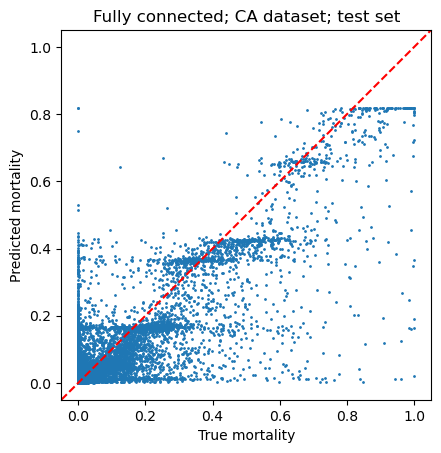

In [16]:
from matplotlib import pyplot as plt

plt.scatter(y_test, yhat, s=1)
plt.xlabel("True mortality")
plt.ylabel("Predicted mortality")
plt.title("Fully connected; CA dataset; test set")
plt.axline((0, 0), (1, 1), c="red", linestyle="dashed")
plt.gca().set_aspect("equal")

In [25]:
import os
from tbparse import SummaryReader

logdir = "logs/preisler_rectangular_v2_lstm/"

all_performance = pd.DataFrame(dict(step=[], tag=[], value=[], model=[], phase=[]))

for model in os.listdir(logdir):
    for phase in ("train", "validation"):
        reader = SummaryReader(os.path.join(logdir, model, phase))
        this_df = reader.tensors[reader.tensors.tag == "epoch_rmse"]
        this_df["model"] = model
        this_df["phase"] = phase
        all_performance = pd.concat((all_performance, this_df))

In [34]:
all_performance["lookback"] = all_performance.model.apply(lambda x: int(x[x.index("_")+1:]))

validation = all_performance[all_performance.phase=="validation"].groupby("model", as_index=False).min()

<Axes: xlabel='lookback'>

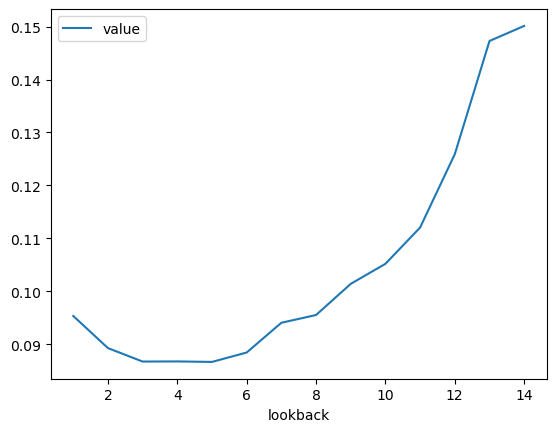

In [40]:
validation.sort_values("lookback").plot(x="lookback", y="value", kind="line", legend=False)

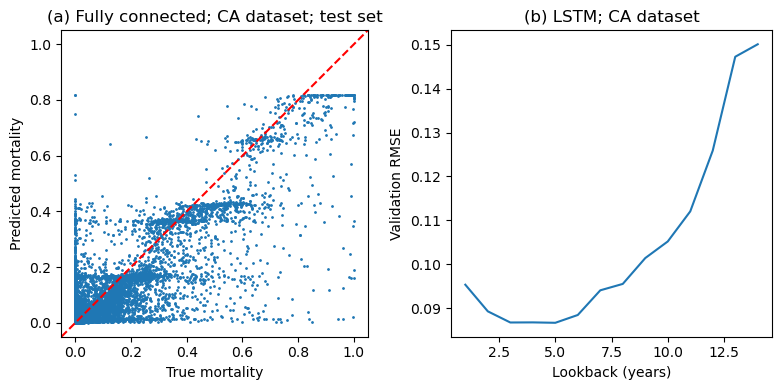

In [52]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

ax1.scatter(y_test, yhat, s=1)
ax1.set_xlabel("True mortality")
ax1.set_ylabel("Predicted mortality")
ax1.set_title("(a) Fully connected; CA dataset; test set")
ax1.axline((0, 0), (1, 1), c="red", linestyle="dashed")
ax1.set_aspect("equal")

validation.sort_values("lookback").plot(
    x="lookback", y="value", kind="line", 
    legend=False, ax=ax2
)
ax2.set_xlabel("Lookback (years)")
ax2.set_ylabel("Validation RMSE")
ax2.set_title("(b) LSTM; CA dataset")

fig.tight_layout()
plt.show()

### Model training

In [9]:
classif_metrics = [
    keras.metrics.Precision(name="precision"),
    keras.metrics.Recall(name="recall"),
    keras.metrics.AUC(name="auc"),
]

regr_metrics = [
    keras.metrics.RootMeanSquaredError(name="rmse"),
    keras.metrics.R2Score(name="r2_score")
]

model = build_preisler_model(init_bias=init_bias)
model.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=0.005),
    metrics=regr_metrics
)

In [10]:
# Callbacks
# NOTE THAT SUBCLASSED MODELS WONT SAVE IF THE FILENAME ENDS IN .keras!
model_name = "preisler_regr_noyear.keras"
earlystop = keras.callbacks.EarlyStopping(monitor="loss", patience=5)
checkpoint = keras.callbacks.ModelCheckpoint(os.path.join("data_working", "models", model_name), save_best_only=True)
logdir = os.path.join("logs", model_name)
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

# Make log directory
os.makedirs(logdir, exist_ok=True)
# Delete any old logs that might be in there
for fname in os.listdir(logdir):
    file_path = os.path.join(logdir, fname)
    try:
        if os.path.isfile(file_path) or os.path.islink(file_path):
            os.unlink(file_path)
        elif os.path.isdir(file_path):
            shutil.rmtree(file_path)
    except OSError as e:
        print("Failed to delete", file_path)

In [11]:
batch_size = 512

history = model.fit(
    x=X_train,
    y=y_train,
    batch_size=batch_size,
    validation_data=(X_valid, y_valid),
    validation_batch_size=batch_size,
    epochs=30,
    verbose=1,
    callbacks=[checkpoint, earlystop, tensorboard_callback]
)

Epoch 1/30


/srv/conda/envs/notebook/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['fire', 'near', 'latitude', 'longitude', 'prcp1', 'prcp2', 'prcp3', 'prcp4', 'rhost', 'winter_tmin']. Received: the structure of inputs=('*', '*', '*', '*', '*', '*', '*', '*', '*', '*')
  warnings.warn(


498/498 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1717 - r2_score: -0.8723 - rmse: 0.1446

/srv/conda/envs/notebook/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['fire', 'near', 'latitude', 'longitude', 'prcp1', 'prcp2', 'prcp3', 'prcp4', 'rhost', 'winter_tmin']. Received: the structure of inputs=('*', '*', '*', '*', '*', '*', '*', '*', '*', '*')
  warnings.warn(


498/498 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.1717 - r2_score: -0.8702 - rmse: 0.1445 - val_loss: 0.1090 - val_r2_score: 0.5571 - val_rmse: 0.0778
Epoch 2/30
498/498 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.1105 - r2_score: 0.5254 - rmse: 0.0794 - val_loss: 0.1047 - val_r2_score: 0.6095 - val_rmse: 0.0731
Epoch 3/30
498/498 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.1066 - r2_score: 0.5795 - rmse: 0.0752 - val_loss: 0.1026 - val_r2_score: 0.6480 - val_rmse: 0.0694
Epoch 4/30
498/498 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.1055 - r2_score: 0.5953 - rmse: 0.0739 - val_loss: 0.1027 - val_r2_score: 0.6469 - val_rmse: 0.0695
Epoch 5/30
498/498 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.1046 - r2_score: 0.6156 - rmse: 0.0722 - val_loss: 0.1022 - val_r2_score: 0.6521 - val_rmse: 0.0690
Epoch 6/30
498/498 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.1037 - r2_score: 0.6141 - rmse: 0.0721 - val_loss: 0.1026 - val_r2_score: 0.6421 - val_rmse: 0.0700
Epoch 7/30
498/498 ━━━━━━━━━━━━━━━━━━━

Train an RF and multiple logreg for comparison.

In [22]:
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler

# Scale data
scaler = StandardScaler()
X_train_scale = scaler.fit_transform(ds_train[BANDS].to_numpy())
X_test_scale  = scaler.transform(ds_test[BANDS].to_numpy())

# Instantiate models
logreg = LogisticRegression()
ridge  = Ridge()
rf     = RandomForestRegressor(n_estimators=100, min_samples_split=50, max_depth=4)

In [23]:
logreg.fit(X_train_scale, y_train > 0)

/srv/conda/envs/notebook/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression()

In [24]:
ridge.fit(X_train_scale, y_train)

Ridge()

In [25]:
rf.fit(X_train_scale, y_train)

/srv/conda/envs/notebook/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestRegressor(max_depth=4, min_samples_split=50)

In [26]:
y_hat_logreg = logreg.predict_proba(X_test_scale)[:, 0]
y_hat_ridge  = ridge.predict(X_test_scale)
y_hat_rf     = rf.predict(X_test_scale)

In [27]:
def one_to_one_plot(y_actual, y_predicted):
    plt.scatter(y_actual, y_predicted, s=1, c="b")
    plt.xlabel("True % Mortality")
    plt.ylabel("Predicted % Mortality")
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.gca().set_aspect("equal")
    return plt.gcf()

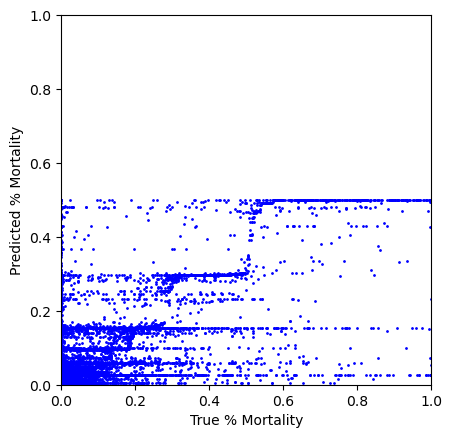

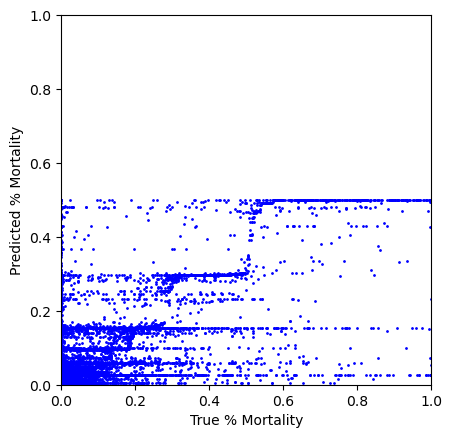

In [30]:
one_to_one_plot(y_test, y_hat_rf)

### Show fit on training data

In [12]:
y_train = ds_train.pct_mortality
y_train_hat = model.predict(X_train, batch_size=batch_size).squeeze()

498/498 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


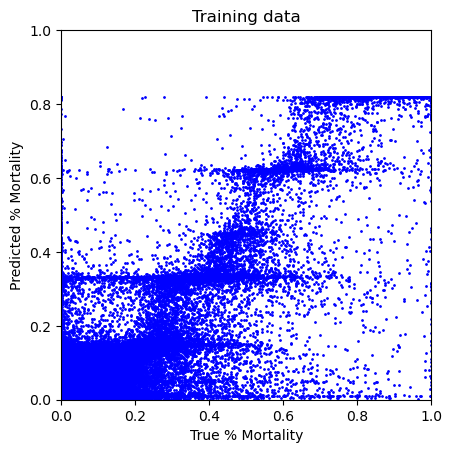

In [13]:

def one_to_one_plot(y_actual, y_predicted):
    plt.scatter(y_actual, y_predicted, s=1, c="b")
    plt.xlabel("True % Mortality")
    plt.ylabel("Predicted % Mortality")
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.gca().set_aspect("equal")
    return plt.gcf()

one_to_one_plot(y_train, y_train_hat)
plt.title("Training data")
plt.show()

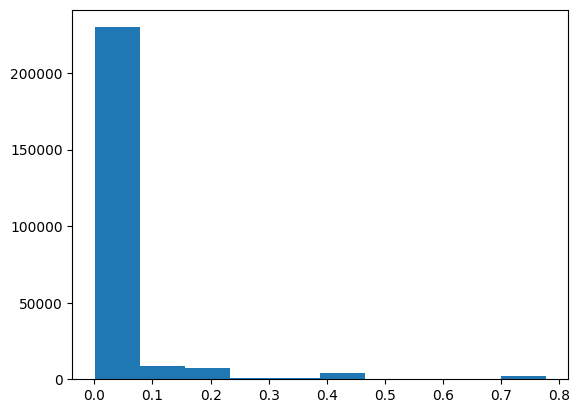

In [16]:
plt.hist(y_train_hat)
plt.show()

In [ ]:
'''
RocCurveDisplay.from_predictions(y_train, y_train_hat)
plt.title("Training")
plt.show()
'''

### Evaluate on test data

71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


Text(0.5, 1.0, 'Test data')

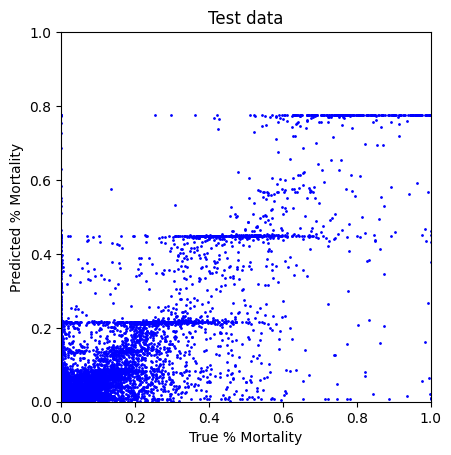

In [17]:
y_test = ds_test.pct_mortality
y_test_hat = model.predict(X_test, batch_size=batch_size).squeeze()

one_to_one_plot(y_test, y_test_hat)
plt.title("Test data")

In [ ]:
'''
RocCurveDisplay.from_predictions(y_test, y_test_hat)
plt.title("Test Data")
plt.show()
'''

### Prepare for export to Google Cloud

Wrap in serialization and deserialization layers

In [ ]:
class StackBands(keras.layers.Layer):
    def __init__(self, add_spatial_dims = False, **kwargs):
        super(StackBands, self).__init__(**kwargs)
        self.add_spatial_dims = add_spatial_dims

    def call(self, features_dict):
        # Stack all inputs into one tensor so we don't have to manually make an input
        # layer for each band.
        concat = tf.concat([features_dict[b] for b in BANDS], axis=-1)
        if self.add_spatial_dims:
            # (None, P) -> (None, 1, 1, P)
            # Where None is batch dim and P is the number of bands
            # The additional axes are necesary if the model is to be deployed on Gcloud
            return tf.expand_dims(tf.expand_dims(concat, axis=1), axis=1)
        else:
            return concat

    def get_config(self):
        return super().get_config()

class StackBandsModel(keras.Model):
    def __init__(self, preprocessing, base_model, **kwargs):
        super().__init__(**kwargs)
        self.preprocessing = preprocessing
        self.base_model = base_model

    def call(self, features_dict):
        return self.base_model(self.preprocessing(features_dict))

    def get_config(self):
        return super().get_config()

In [ ]:
# From https://github.com/google/earthengine-community/blob/master/guides/linked/Earth_Engine_TensorFlow_Vertex_AI.ipynb
class DeSerializeInput(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super().__init__(**kwargs)

  def call(self, inputs_dict):
    return {
      k: tf.map_fn(lambda x: tf.io.parse_tensor(x, tf.float32),
                   tf.io.decode_base64(v),
                   fn_output_signature=tf.float32)
        for (k, v) in inputs_dict.items()
    }

  def get_config(self):
    config = super().get_config()
    return config


class ReSerializeOutput(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super().__init__(**kwargs)

  def call(self, output_tensor):
    return tf.map_fn(lambda x: tf.io.encode_base64(tf.io.serialize_tensor(x)),
                    output_tensor,
                    fn_output_signature=tf.string)

  def get_config(self):
    config = super().get_config()
    return config

input_deserializer = DeSerializeInput()
output_deserializer = ReSerializeOutput()

serialized_inputs = {
    b: tf.keras.Input(shape=[], dtype='string', name=b) for b in BANDS
}

updated_model_input = input_deserializer(serialized_inputs)
updated_model = model(updated_model_input)
updated_model = output_deserializer(updated_model)
updated_model= tf.keras.Model(serialized_inputs, updated_model)

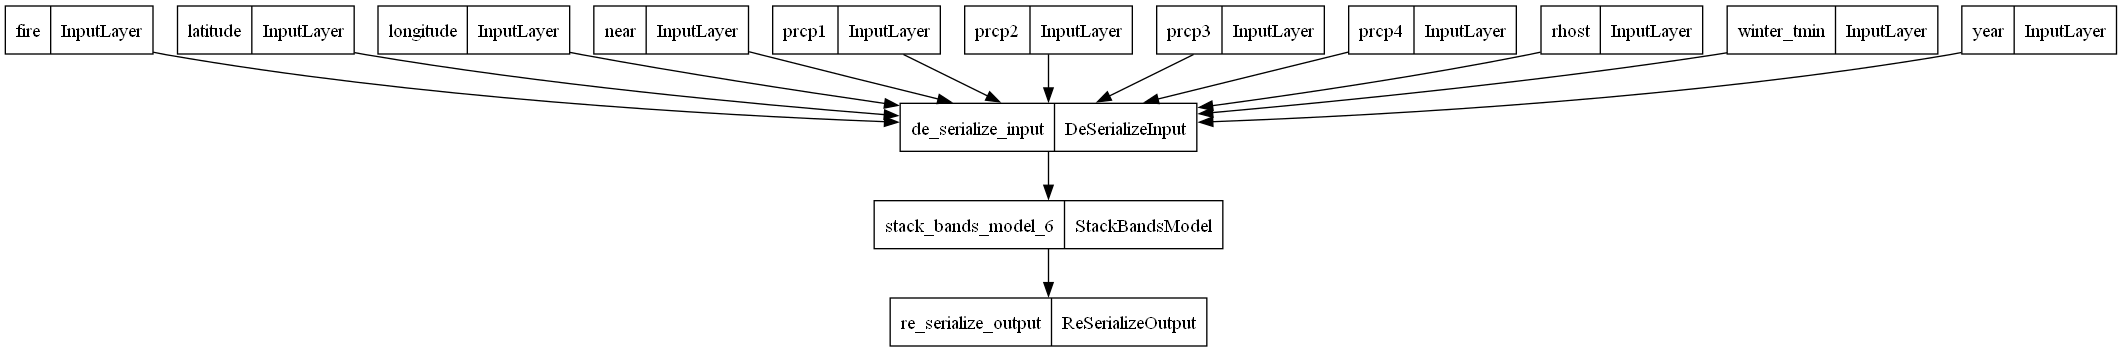

In [ ]:
tf.keras.utils.plot_model(updated_model)

In [ ]:
# Save trained model
MODEL_DIR = "gs://" + bucket + "/model"

In [ ]:
!gsutil rm -r {MODEL_DIR}

CommandException: No URLs matched: gs://preisler_tfdata/model


In [ ]:
updated_model.save("data_working/models/preisler_classif_gcloud.tf")

INFO:tensorflow:Assets written to: data_working/models/preisler_classif_gcloud.tf\assets


In [ ]:
!gsutil cp -r data_working/models/preisler_classif_gcloud.tf/ gs://{bucket}

Copying file://data_working\models\preisler_classif_gcloud.tf\saved_model.pb [Content-Type=application/octet-stream]...
/ [0 files][    0.0 B/  1.0 MiB]                                                
/ [1 files][  1.0 MiB/  1.0 MiB]                                                
Copying file://data_working\models\preisler_classif_gcloud.tf\keras_metadata.pb [Content-Type=application/octet-stream]...
/ [1 files][  1.0 MiB/  1.1 MiB]                                                
/ [2 files][  1.1 MiB/  1.1 MiB]                                                
-
Copying file://data_working\models\preisler_classif_gcloud.tf\variables\variables.data-00000-of-00001 [Content-Type=application/octet-stream]...
- [2 files][  1.1 MiB/  1.2 MiB]                                                
- [3 files][  1.2 MiB/  1.2 MiB]                                                
Copying file://data_working\models\preisler_classif_gcloud.tf\variables\variables.index [Content-Type=application/octet-stre

### Deploy model
Note this part costs money!

In [ ]:
!gcloud ai models upload \
  --artifact-uri=gs://preisler_tfdata/preisler_classif_gcloud.tf \
  --project=forest-lst \
  --region=us-west1 \
  --container-image-uri=us-docker.pkg.dev/vertex-ai/prediction/tf2-cpu.2-11:latest \
  --description=preisler_demo \
  --display-name=preisler_demo \
  --model-id=preisler_demo

Using endpoint [https://us-west1-aiplatform.googleapis.com/]
Waiting for operation [8838341206749478912]...
.......................done.


Create the endpoint

In [ ]:
!gcloud ai endpoints create \
  --display-name=preisler-demo \
  --region=us-west1 \
  --project=forest-lst

^C


Using endpoint [https://us-west1-aiplatform.googleapis.com/]
Waiting for operation [7372788963947315200]...
............................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

Get the endpoint ID

In [ ]:
ENDPOINT_ID = !gcloud ai endpoints list \
  --project=forest-lst \
  --region=us-west1 \
  --filter=displayName:preisler-demo \
  --format="value(ENDPOINT_ID.scope())"
ENDPOINT_ID = ENDPOINT_ID[-1]

In [ ]:
print(ENDPOINT_ID)

5099592104229732352


Deploy the model

In [ ]:
!gcloud ai endpoints deploy-model {ENDPOINT_ID} \
  --project=forest-lst \
  --region=us-west1 \
  --model=preisler_demo \
  --display-name=preisler-demo

Using endpoint [https://us-west1-aiplatform.googleapis.com/]
Waiting for operation [7868941386957979648]...
............................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

### Run model

Pull an image from which the training was derived, pass to model, visualize result.

In [ ]:
import ee
import geemap
ee.Initialize()

In [ ]:
example_image = ee.Image("projects/forest-lst/assets/preisler-annual-images/2003")

Map = geemap.Map()
Map.addLayer(example_image.select("pct_mortality").gt(0))
Map

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

In [ ]:
endpoint_path = (
    'projects/' + "forest-lst" + '/locations/' + "us-west1" + '/endpoints/' + str(ENDPOINT_ID))

# Connect to the hosted model.
vertex_model = ee.Model.fromVertexAi(
  endpoint=endpoint_path,
  inputTileSize=[1, 1],
  proj=example_image.select("pct_mortality").projection().atScale(4000),
  fixInputProj=True,
  outputBands={'output': {
      'type': ee.PixelType.float(),
      'dimensions': 1
    }
  })

In [ ]:
BANDS   = ["fire", "near", "latitude", "longitude", "prcp1", "prcp2", "prcp3", "prcp4", "rhost", "winter_tmin", "year"]
prediction = vertex_model.predictImage(example_image.select(BANDS).float()).arrayFlatten([["predict_mortality"]])

In [ ]:
Map = geemap.Map()

Map.addLayer(example_image.select("pct_mortality").gt(0), name="true mortality")
Map.addLayer(prediction, name="model prediction")

Map

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

### Export model predictions

For display in an EE app.

In [ ]:
ic_path = "projects/forest-lst/assets/preisler-annual-images"
annual_images = ee.ImageCollection(ic_path)
img_idxs = annual_images.aggregate_array("system:index").getInfo()

def do_model_prediction(ic, idx):
    img = ee.Image(ic_path+"/"+idx)
    return vertex_model.predictImage(img.select(BANDS).float())\
        .arrayFlatten([["predict_mortality"]])\
        .set("system:time_start", img.get("system:time_start"))\
        .set("system:time_end", img.get("system:time_end"))

annual_image_predict = list(map(lambda x: do_model_prediction(annual_images, x), img_idxs))

In [ ]:
!earthengine create collection projects/forest-lst/assets/preisler-annual-image-prediction

In [ ]:
!earthengine rm -r projects/forest-lst/assets/preisler-annual-image-prediction

In [ ]:
import datetime

def prediction_export_task(img):
    ms = img.get("system:time_start").getInfo()
    year = datetime.datetime.utcfromtimestamp(ms/1000.0).year
    
    return ee.batch.Export.image.toAsset(
        image=img,
        description="preisler-annual-image-prediction-{}".format(year),
        assetId="projects/forest-lst/assets/preisler-annual-image-prediction/{}".format(year),
        scale=4000,
        crs=img.projection()
    )

tasks = [prediction_export_task(img) for img in annual_image_predict]

In [ ]:
for t in tasks: t.start()